# Library import

In [21]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [22]:
userPATH ='revision_dataset/'
tweetPATH = 'revision_dataset/tweetAgg/'

In [23]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [24]:
## matching nonperson only
nonpersontrain = userlvltrain[userlvltrain['isaPerson']=="nonperson"]
nonpersontest = userlvltest[userlvltest['isaPerson']=="nonperson"]
nonpersonval = userlvlval[userlvlval['isaPerson']=="nonperson"]

In [25]:
train_df = pd.read_csv(tweetPATH+'aggtrain_df.csv')
train_df['screen_name'] = userlvltrain.screen_name
train_df['userLocation'] = userlvltrain.userLocation

test_df = pd.read_csv(tweetPATH+'aggtest_df.csv')
test_df['screen_name'] = userlvltest.screen_name
test_df['userLocation'] = userlvltest.userLocation

val_df = pd.read_csv(tweetPATH+'aggval_df.csv')
val_df['screen_name'] = userlvlval.screen_name
val_df['userLocation'] = userlvlval.userLocation

In [26]:
train_df = train_df[train_df['screen_name'].isin(nonpersontrain['screen_name'])]
print(set(train_df.screen_name)-set(nonpersontrain.screen_name))

test_df = test_df[test_df['screen_name'].isin(nonpersontest['screen_name'])]
print(set(test_df.screen_name)-set(nonpersontest.screen_name))

val_df = val_df[val_df['screen_name'].isin(nonpersonval['screen_name'])]
print(set(val_df.screen_name)-set(nonpersonval.screen_name))

train_df.head(3)

set()
set()
set()


,text,screen_name,userLocation
2,selamat tretan semoga harapanharapan terwujud ...,MaduraUnitedFC,jawa timur
3,selamat pagi apakabar hi hi kak dimana nih yuk...,waterbombali,bali dan nusa tenggara
4,pantauan arus lalin terkini ruas jalan simpang...,dishub_jabar,jawa barat dan banten


In [27]:
## prepare data for BERT training and save in newdata/
if not os.path.exists('nonpersondata/'): 
    os.mkdir('nonpersondata/')
    train_df.to_csv('nonpersondata/train.csv', index=False)
    test_df.to_csv('nonpersondata/test.csv', index=False)
    val_df.to_csv('nonpersondata/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [28]:
!nvidia-smi

Tue Mar 22 06:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    57W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0   166W / 300W |  16646MiB / 32480MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [29]:
torch.cuda.set_device(7)
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:7"
torch.cuda.current_device()

7

In [30]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [31]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=config)

train_dataset = LocationPredictionDataset("nonpersondata/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("nonpersondata/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("nonpersondata/test.csv", tokenizer, lowercase=True)


learning_rate = 2e-5
batch_size = 16
epochs = 7

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [33]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

In [34]:
file_path = 'nonperson_saved_model'

### training

In [35]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")


# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(file_path + '/indoNLU_model_2e_5_batch16.pt', model, optimizer, best_valid_loss)

save_metrics(file_path + '/indoNLU_metrics_2e_5_batch16.pt', train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:2.2207 LR:0.00002000: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


(Epoch 1) TRAIN LOSS:2.2207 ACC:0.15 F1:0.13 REC:0.14 PRE:0.15 LR:0.00002000


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1785 ACC:0.06 F1:0.04 REC:0.12 PRE:0.03:  33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1226 ACC:0.12 F1:0.05 REC:0.15 PRE:0.03:  67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

(Epoch 1) VALID LOSS:2.0898 ACC:0.15 F1:0.05 REC:0.11 PRE:0.03


(Epoch 2) TRAIN LOSS:1.8378 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


(Epoch 2) TRAIN LOSS:1.8378 ACC:0.41 F1:0.39 REC:0.39 PRE:0.46 LR:0.00002000


VALID LOSS:1.3588 ACC:0.81 F1:0.81 REC:0.85 PRE:0.84:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.3159 ACC:0.75 F1:0.65 REC:0.68 PRE:0.69: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


(Epoch 2) VALID LOSS:1.3159 ACC:0.75 F1:0.65 REC:0.68 PRE:0.69


(Epoch 3) TRAIN LOSS:1.0148 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


(Epoch 3) TRAIN LOSS:1.0148 ACC:0.82 F1:0.81 REC:0.81 PRE:0.82 LR:0.00002000


VALID LOSS:0.8757 ACC:0.81 F1:0.81 REC:0.83 PRE:0.81:  33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.7425 ACC:0.85 F1:0.82 REC:0.87 PRE:0.82: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


(Epoch 3) VALID LOSS:0.7425 ACC:0.85 F1:0.82 REC:0.87 PRE:0.82


(Epoch 4) TRAIN LOSS:0.4954 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


(Epoch 4) TRAIN LOSS:0.4954 ACC:0.89 F1:0.88 REC:0.88 PRE:0.88 LR:0.00002000


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.8437 ACC:0.75 F1:0.67 REC:0.70 PRE:0.72:  33%|███▎      | 1/3 [00:01<00:03,  1.69s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6086 ACC:0.83 F1:0.80 REC:0.84 PRE:0.83: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


(Epoch 4) VALID LOSS:0.6086 ACC:0.83 F1:0.80 REC:0.84 PRE:0.83


(Epoch 5) TRAIN LOSS:0.2792 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


(Epoch 5) TRAIN LOSS:0.2792 ACC:0.94 F1:0.94 REC:0.93 PRE:0.94 LR:0.00002000


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0442 ACC:0.75 F1:0.67 REC:0.70 PRE:0.72:  33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6139 ACC:0.83 F1:0.79 REC:0.84 PRE:0.83: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


(Epoch 5) VALID LOSS:0.6139 ACC:0.83 F1:0.79 REC:0.84 PRE:0.83


(Epoch 6) TRAIN LOSS:0.1826 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


(Epoch 6) TRAIN LOSS:0.1826 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00002000


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0056 ACC:0.75 F1:0.67 REC:0.70 PRE:0.72:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.5621 ACC:0.85 F1:0.81 REC:0.86 PRE:0.84: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


(Epoch 6) VALID LOSS:0.5621 ACC:0.85 F1:0.81 REC:0.86 PRE:0.84


(Epoch 7) TRAIN LOSS:0.1319 LR:0.00002000: 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


(Epoch 7) TRAIN LOSS:0.1319 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97 LR:0.00002000


  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.8776 ACC:0.75 F1:0.67 REC:0.70 PRE:0.72:  33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.5716 ACC:0.85 F1:0.83 REC:0.86 PRE:0.85: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

(Epoch 7) VALID LOSS:0.5716 ACC:0.85 F1:0.83 REC:0.86 PRE:0.85
Done Training!


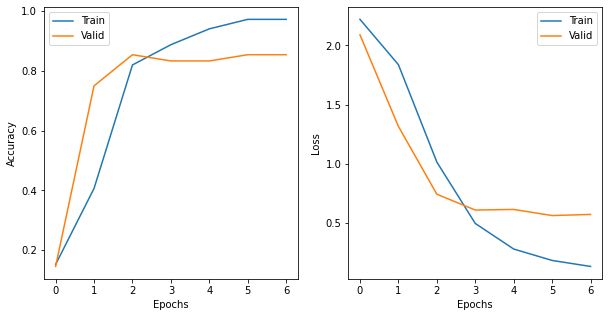

In [36]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(file_path + '/indoNLU_metrics_2e_5_batch16.pt')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

In [37]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=2e-5)

load_checkpoint(file_path + '/indoNLU_model_2e_5_batch16.pt', best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


In [40]:
## get y_test for user level
y_test_user_lvl = nonpersontest.Lvalue
y_test_user_lvl.values

array([7, 4, 1, 7, 3, 7, 0, 2, 6, 7, 2, 1, 3, 2, 3, 1, 1, 8, 0, 8, 8, 2,
       1, 7, 0, 4, 3, 4, 0, 4, 3, 3, 7, 3, 3, 3, 1, 6, 5, 8, 3, 6, 4, 1,
       5, 2, 5, 8, 2, 4, 7, 1, 2, 0, 8, 2, 0, 0, 4, 8, 2, 7, 7, 2, 5, 3,
       4, 4, 4, 2, 1, 1, 5, 3, 6, 0, 6, 1, 6, 8, 0, 7, 4, 6, 8, 3, 6, 6,
       3, 1, 5, 1, 8, 0, 4, 6, 2, 6, 4, 0, 8, 4, 7, 8, 5, 4, 3, 8, 1, 2,
       1, 3, 4, 1, 7, 3])

In [41]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes
y_pred_tweets_lvl.values

array([6, 4, 1, 7, 3, 7, 0, 2, 6, 7, 2, 2, 3, 3, 3, 5, 1, 8, 0, 8, 8, 2,
       1, 7, 0, 4, 1, 4, 0, 4, 3, 3, 7, 3, 2, 3, 4, 6, 5, 8, 3, 6, 3, 5,
       5, 2, 5, 2, 1, 4, 1, 1, 2, 0, 8, 2, 0, 0, 4, 8, 1, 7, 1, 2, 5, 3,
       4, 4, 4, 2, 1, 1, 5, 3, 6, 6, 6, 1, 6, 8, 0, 7, 4, 6, 8, 3, 6, 6,
       3, 7, 5, 1, 8, 0, 4, 6, 2, 6, 4, 0, 8, 4, 7, 8, 5, 4, 3, 8, 0, 1,
       1, 3, 4, 1, 7, 3], dtype=int8)

In [42]:
from sklearn.metrics import classification_report, accuracy_score

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_test_user_lvl, y_pred_tweets_lvl),2 ))
print(classification_report(y_test_user_lvl, y_pred_tweets_lvl,target_names=label_dict.keys()))

accuracy 0.84
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.91      0.91      0.91        11
               jabodetabek       0.62      0.62      0.62        16
     jawa barat dan banten       0.75      0.69      0.72        13
jawa tengah dan yogyakarta       0.88      0.88      0.88        17
                jawa timur       0.94      0.94      0.94        16
                kalimantan       0.78      1.00      0.88         7
          maluku dan papua       0.85      1.00      0.92        11
                  sulawesi       0.90      0.75      0.82        12
                  sumatera       1.00      0.92      0.96        13

                  accuracy                           0.84       116
                 macro avg       0.85      0.86      0.85       116
              weighted avg       0.85      0.84      0.84       116



## Test Person to non person

In [43]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=2e-5)

file_path = 'person_saved_model'

load_checkpoint(file_path + '/indoNLU_model_2e_5_batch16.pt', best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


In [45]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report


## get y_pred for tweets level
y_pred_tweets_lvl_person = df.iloc[:,1].astype('category')
y_pred_tweets_lvl_person = y_pred_tweets_lvl_person.cat.codes


## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(nonpersontest.Lvalue, y_pred_tweets_lvl_person),2 ))
print(classification_report(nonpersontest.Lvalue, y_pred_tweets_lvl_person,target_names=label_dict.keys()))

accuracy 0.6
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.71      0.91      0.80        11
               jabodetabek       0.50      0.56      0.53        16
     jawa barat dan banten       0.75      0.23      0.35        13
jawa tengah dan yogyakarta       0.44      0.82      0.57        17
                jawa timur       0.67      0.12      0.21        16
                kalimantan       0.83      0.71      0.77         7
          maluku dan papua       0.71      0.91      0.80        11
                  sulawesi       0.67      0.83      0.74        12
                  sumatera       0.70      0.54      0.61        13

                  accuracy                           0.60       116
                 macro avg       0.66      0.63      0.60       116
              weighted avg       0.64      0.60      0.57       116

